In [36]:
import numpy as np
import qutip as qt
import scipy.stats as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import random

In [78]:
def generate_prior_ginibre(n):
    # draw n states from the ginibre distribution (unbiased)
    s = [qt.sigmax(), qt.sigmay(), qt.sigmaz()] 
    x_0 = np.zeros((n, 3))
    w_0 = np.ones(n)/n
    for i in range(n):
        dm = qt.rand_dm_ginibre(dim)
        x_0[i] = np.array([qt.expect(j, dm) for j in s]) # calculate pauli representation
    return x_0, w_0

def pauli_measurement(rho, c):
    # create a measurement outcome of the state rho (in pauli representation) when measured in basis c
    prob = (rho[c]+1)/2
    if random.uniform(0, 1) < prob: res = 1
    else: res = 0
    return res

def pauli_experiment(rho, c, rep):
    # measure rho pauli basises specified in c, repear ech measurement rep times, return # of measuered 1s
    c_rep = np.tile(c, [rep, 1]).flatten('F') # repeated measurements
    d_rep = np.array([pauli_measurement(rho, c_i) for c_i in c_rep]) # generate random measurements on rho     
    return np.sum(np.reshape(d_rep, (len(c), meas_rep)), axis= 1) # sum over measurement repetitions
    
def likelihood(x, d, c, rep):
    # calculate likelihood of measurement outcome d given that the state is x
    p = (x[:, c] + 1) / 2
    return np.array([sp.binom.pmf(d, rep, p[i]) for i in range(len(x))])

def update_weights(x, w, d, c, rep):
    # update weights according to likelihood and normalize, check whether resampling is required
    w_new = w * likelihood(x, d, c, rep)
    w_new = np.divide(w_new, np.sum(w_new))
    n_eff = 1 / np.sum(w_new**2)
    if n_eff / len(w) < thr_resampling: resampling_required = 1
    else: resampling_required = 0
    return w_new, resampling_required

def pointestimate(x, w):
    # return point estimate of rho
    return np.average(x, axis=0, weights= w)

def resample_lw(x, w, h= 0.14, a= 0.99):
    # resampling points from x with weights w according to Liu and West algorithm
    x_out = []
    mu = pointestimate(x, w)
    cov = h**2 * np.cov(x, aweights= w, rowvar= 0)
    for i in range(len(x)):
        j = np.random.choice(len(x), p= w)
        mu_i = a * x[j] + (1 - a) * mu
        valid_state = 0
        while valid_state == 0:
            temp = np.random.multivariate_normal(mu_i, cov)
            if np.sum(temp**2) <= 1: valid_state = 1
        x_out.append(temp)
    w_out = np.divide(np.ones(len(x)), len(x))
    return np.array(x_out), w_out

def fidelity(a, b):
    # compute fidelity from density matrices in Pauli representation
    s = [qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    a_dm = 1/2 * qt.qeye(2)
    b_dm = 1/2 * qt.qeye(2)
    for ids, s_i in enumerate(s):
        a_dm += 1/2 * (s_i * a[ids])
        b_dm += 1/2 * (s_i * b[ids])
    return qt.metrics.fidelity(a_dm, b_dm)

def plot2D_samples(x, w, rho, rho_est, r= 0.02, proj= [0, 1], scale= 0.1, size= (10, 10)):
    # plot sample points
    fig = plt.figure(figsize=(size)) 
    plt.gca().add_patch(plt.Circle((0, 0), 1, ec='black', fc=None, fill= 0)) 
    plt.scatter(x[:,proj[0]], x[:,proj[1]], s= w * len(w) * scale)
    confidence_ellipse(x.T[proj], w, rho_est, plt.gca(), n_std=3.0)
    plt.scatter(rho[proj[0]], rho[proj[1]], c='red', s=400 * scale)
    plt.scatter(rho_est[proj[0]], rho_est[proj[1]], c='orange', s= 400 * scale, marker= 'X')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.show()
    
def confidence_ellipse(x, w, rho_est, ax, n_std=3.0, fc='none', ec='orange', **kwargs):
    # create confidence ellipse, n_std = 3.0 cooresponds to 98.5% confidence interval
    cov = np.cov(x, aweights= w)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, fc= fc, ec= ec, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(rho_est[0], rho_est[1])
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [87]:
n_q = 1 # number of Qubits - fixed in this implementation
dim = 2**n_q # Dimension of Hilbert space

# ideal state
rho = np.array([0.7, 0.3, 0])

# Experiments in Pauli basis
n_meas = 1000 # number of measurements
meas_rep = 16 # number of repetitions of measurement
c_meas = np.random.randint(0, 3, n_meas) # random measurement basis

# SMC parameters
n = 2000 # number of sampling points
thr_resampling = 0.5 # resampling threshold
a = 0.99 # resampling parameter
h = np.sqrt(1-a**2) # [a^2+h^2=1] makes sure the resampled covariance stays the same
flag_resampling = 0 # resampling required

[ 0.69895092  0.29155813 -0.01195576]
0.014673307179197242


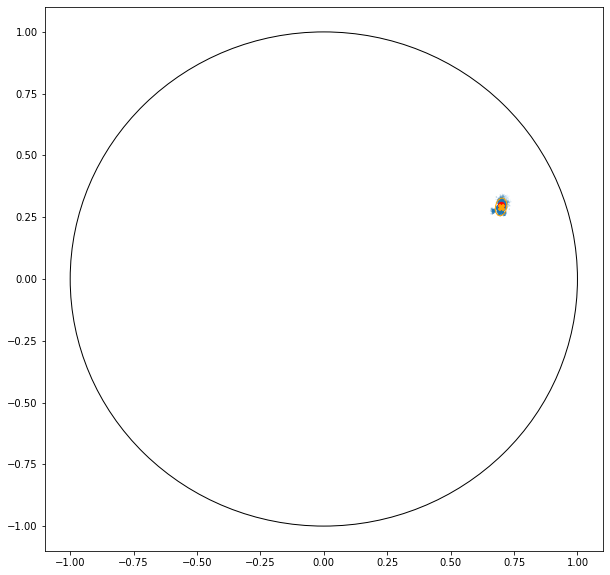

In [88]:
# Experiments
d_meas = pauli_experiment(rho, c_meas, meas_rep)

# Generate particle cloud according to unbiased ginibre prior
x, w = generate_prior_ginibre(n)

# Update the sequential Monte Carlo particle cloud
for i in range(n_meas):
    w, flag_resampling = update_weights(x, w, d_meas[i], c_meas[i], meas_rep)
    if flag_resampling == 1:
        x, w = resample_lw(x, w, h= h, a= a)
        flag_resampling = 0

# Estimates
rho_est = pointestimate(x, w)
loss = quadratic_loss(rho_est, rho)
cov = np.cov(x, aweights= w, rowvar= 0)
print(rho_est)
print(loss)

# Plot particle cloud
plot2D_samples(x, w, rho, rho_est)